In [73]:
import os
import sys

sys.path.append('../')

import numpy as np
import torch
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm, Normalize
from matplotlib.gridspec import GridSpec

from kwave.ktransducer import kWaveGrid
from models.pact import Wavefront2TF, SOS2Wavefront
from utils.dataio import load_mat
from utils.reconstruction import get_coordinates
from utils.simulations import get_water_sos
from utils.utils_torch import crop_half, get_fourier_coord
from utils.visualization import *

data_path = '../data/'

### Load SOS

In [74]:
SOS_phantom = load_mat(os.path.join(data_path, 'SOS_easy.mat'))
SOS_SB = load_mat(os.path.join(data_path, 'SOS_SB.mat'))
SOS_body = load_mat(os.path.join(data_path, 'SOS_body.mat'))
SOS_body_liver = load_mat(os.path.join(data_path, 'SOS_body_liver.mat'))
SOS_uniform = load_mat(os.path.join(data_path, 'SOS_uniform.mat'))

In [75]:
Nx, Ny = 560, 560
dx, dy = 4e-5, 4e-5
N, l = 80, 3.2e-3
i, j = 18, 15
idx, idy = 20*i+40, 20*j+40
x, y, r, phi = get_coordinates(i, j, l)
k2D, theta2D = get_fourier_coord(N=N, l=l, device='cpu')
kgrid = kWaveGrid([Nx, Ny], [dx, dy])
x_vec, y_vec = kgrid.x_vec, kgrid.y_vec

In [76]:
R = 9.8e-3 # Radius to center [m].
T = 26.0
v0 = get_water_sos(T) # Background SOS & SOS in tissue [m/s].

In [77]:
delays = np.array([0.0, -3e-4])

In [78]:
sos2wf = SOS2Wavefront(R, v0, x_vec, y_vec, n_thetas=360)
sos2wf.cuda()
sos2wf.eval()

wf2tf = Wavefront2TF(N=160, l=6.4e-3, n_delays=delays.shape[0])
wf2tf.cuda()
wf2tf.eval()

Wavefront2TF(
  (interp1d): Interp1D()
)

In [79]:
SOSs = [SOS_uniform, SOS_body_liver, SOS_phantom]
wfs, psfs = [], []
for SOS in SOSs:
    thetas, wf = sos2wf(torch.tensor(x).cuda(), torch.tensor(y).cuda(), torch.tensor(SOS).cuda())
    wfs.append(wf.detach().cpu().numpy())
    tf_stack = wf2tf(torch.tensor(delays).cuda().view(1,-1,1,1), thetas, wf).squeeze(0).detach().cpu()
    psf = crop_half(fftshift((ifft2(tf_stack)), dim=(-2,-1)).real)
    psf /= psf.sum(dim=(-2,-1)).unsqueeze(-1).unsqueeze(-1)
    psfs.append(psf)
thetas = thetas.detach().cpu().numpy()

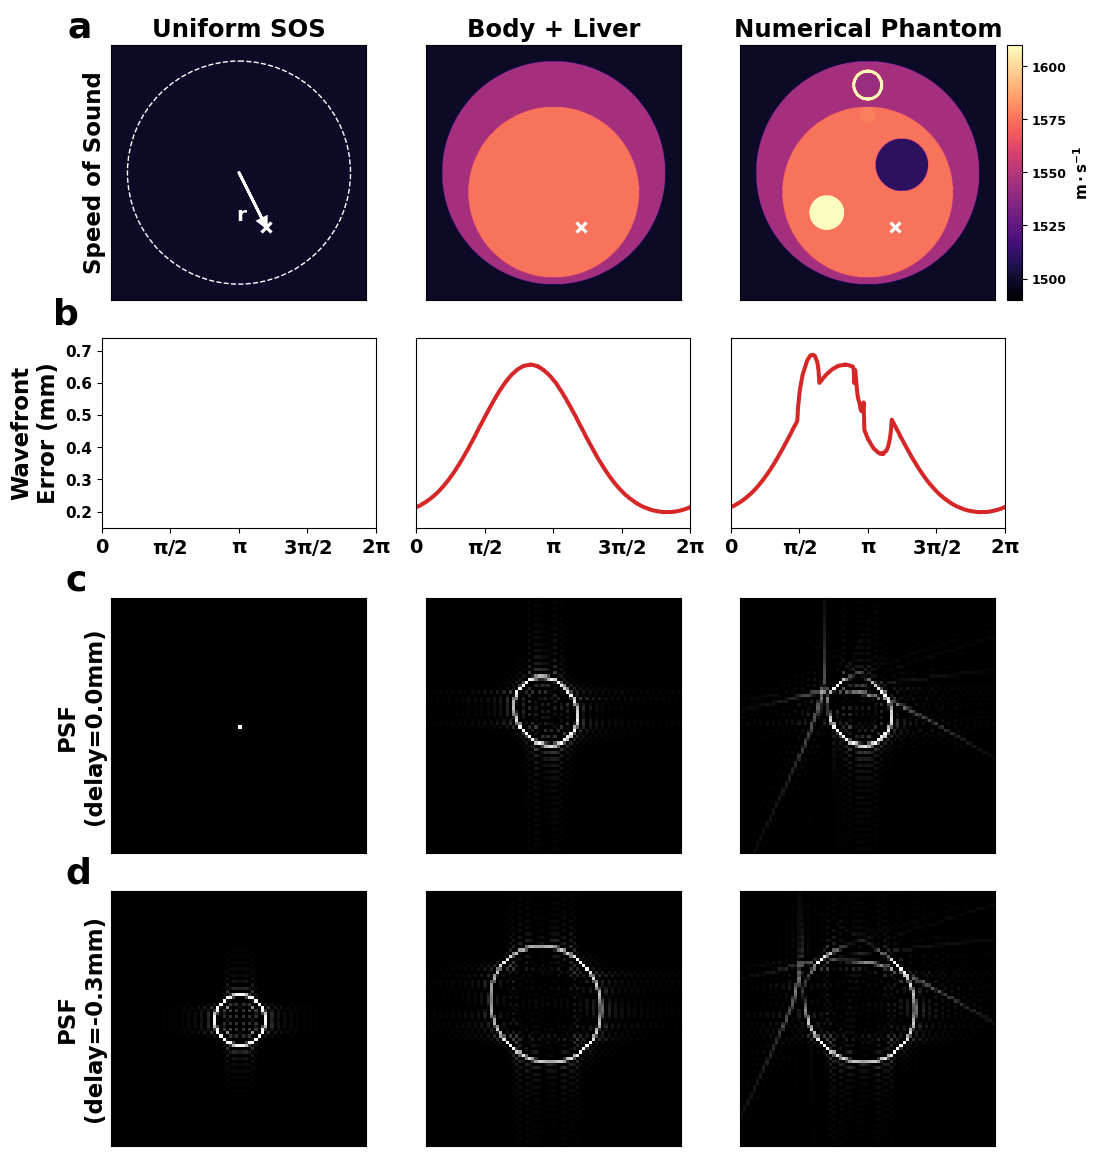

In [80]:
titles = ['Uniform SOS', 'Body + Liver', 'Numerical Phantom']

fig = plt.figure(figsize=(12.1, 14.3))
gs = GridSpec(34, 27)
norm_SOS = Normalize(vmax=1610, vmin=1490)
norm_psf = Normalize(vmin=0.0, vmax=0.08)
for i, (SOS, wf, psf_stack, title) in enumerate(zip(SOSs, wfs, psfs, titles)):
    ax = plt.subplot(gs[0:8,9*i:9*i+8])
    plt.imshow(SOS, norm=norm_SOS, cmap='magma')
    plt.plot(idy, idx, marker='x', mew=2.3, color='white', markersize=7.5)
    plt.title(title, fontsize=17.5, fontweight='bold')
    plt.xticks([])
    plt.yticks([])
    if i == 0:
        plt.arrow(280, 280, (idy-280)*0.85, (idx-280)*0.85, color='white', linewidth=2, head_width=20, head_length=20)
        plt.text(s='r', color='white', x=idy-65, y=idx-15, fontsize=14.5, fontweight='semibold')
        plt.ylabel('Speed of Sound', fontsize=16.5, fontweight='bold')
        plt.title('a', loc='left', x=-0.17, y=1.0, fontsize=26, fontweight='bold', color='black')
        circle = plt.Circle((280, 280), R/4e-5, fill=False, linestyle='--', color='white')
        ax.add_artist(circle)
    elif i == 2:
        cax = fig.add_axes([ax.get_position().x1+0.01, ax.get_position().y0, 0.012, ax.get_position().height])
        cb = plt.colorbar(cax=cax, norm=norm_SOS)
        cb.ax.set_yticks([1500, 1525, 1550, 1575, 1600])
        cb.ax.set_yticklabels(['1500', '1525', '1550', '1575', '1600'], fontweight='bold', fontsize=9)
        cb.set_label('$\mathbf{m \cdot s^{-1}}$', fontsize=11, fontweight='bold')
    
    ax = plt.subplot(gs[9:15,9*i:9*i+8])
    plt.plot(thetas, wf*1e3, color='tab:red', label='True WF', linewidth=2.9)
    # if i in[2, 3]:
    #     plt.plot(thetas, w_apact*1e3, linestyle='--', color='tab:blue', label='APACT')
    #     plt.plot(thetas, w_sb*1e3, linestyle='--', color='tab:purple', label='Single-body')
    #     plt.legend(fontsize=11, loc='best')
    plt.xlim([0, 2*np.pi])
    plt.ylim([0.15, 0.74])
    plt.xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi], 
               ['$\mathbf{0}$', '$\mathbf{\pi/2}$', '$\mathbf{\pi}$', '$\mathbf{3\pi/2}$', '$\mathbf{2\pi}$'], fontsize=14)
    if i == 0:
        plt.ylabel('Wavefront\nError (mm)', fontsize=16.5, fontweight='bold')
        plt.title('b', loc='left', x=-0.18, y=1.03, fontsize=26, fontweight='bold', color='black')
        plt.yticks(fontsize=11, fontweight='bold')
    else:
        plt.yticks([])

    psf1, psf2 = psf_stack[0], psf_stack[1]
    psf1 = torch.clip(psf1, min=0)
    psf1 = torch.clip(psf1, min=0)
    psf2 = torch.clip(psf2, min=0)
    psf2 = torch.clip(psf2, min=0)
    ax = plt.subplot(gs[17:25,9*i:9*i+8])
    plt.imshow(psf1, cmap='gray', norm=norm_psf)
    plt.xticks([])
    plt.yticks([])
    if i == 0:
        plt.ylabel('PSF\n(delay=0.0mm)', fontsize=16.5, fontweight='bold')
        plt.title('c', loc='left', x=-0.18, y=1.0, fontsize=26, fontweight='bold', color='black')
    
    ax = plt.subplot(gs[26:34,9*i:9*i+8])
    plt.imshow(psf2, cmap='gray', norm=norm_psf)
    plt.xticks([])
    plt.yticks([])
    if i == 0:
        plt.ylabel('PSF\n(delay={:.1f}mm)'.format(delays[1]*1e3), fontsize=16.5, fontweight='bold')
        plt.title('d', loc='left', x=-0.18, y=1.0, fontsize=26, fontweight='bold', color='black')
        
plt.savefig('figure_SOS.png', bbox_inches='tight', dpi=256)